# 01. Kigali Road Network Extraction
**Objective**: Extract a clean, drivable road network for the Kigali simulation area.

**Expected Outcome**: A validated SUMO `.net.xml` file and a filtered OpenStreetMap graph.

In [4]:
import sys
import os
from pathlib import Path
import yaml

# Path Management: Ensure src is accessible
root_path = Path(os.getcwd()).parent
if str(root_path) not in sys.path:
    sys.path.append(str(root_path))

# Standard Data Science & Viz Stack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox

# Project-Specific Utilities
from src.utils.logger import setup_logger
from src.utils.debug_helpers import inspect_dict, inspect_array
from src.utils.run_manager import RunManager
from src.utils.cache_utils import load_or_build
from src.viz.map_plots import plot_road_network

# Quality of Life Magics
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Initialize Global Logger
logger = setup_logger("01_extraction")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Task 3: Defining Simulation Scope

Establish the geographical bounding box for the Kigali digital twin. Precise coordinates are required to focus computational resources on the high-incident sectors of Nyarugenge, Gasabo, and Kicukiro, ensuring the simulation covers the primary arterial roads necessary for EMS optimization.


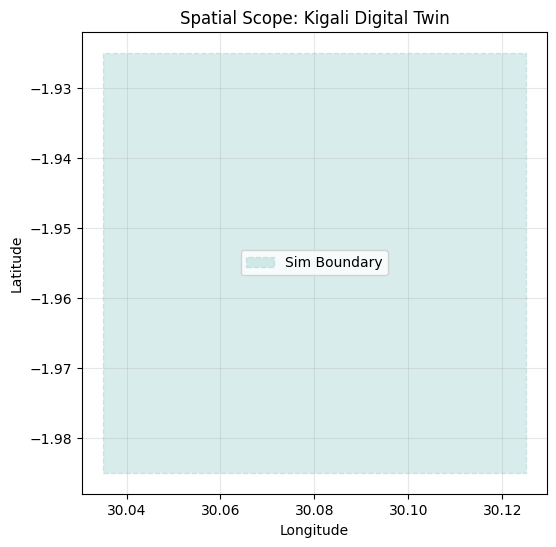

Scope Verified: 30.035, -1.985 to 30.125, -1.925


In [6]:
# 1. Load spatial configuration
config_path = Path("../configs/map_config.yaml")
with open(config_path, "r") as f:
    map_config = yaml.safe_load(f)

# Safety check for empty or malformed file
if map_config is None or 'kigali_bounds' not in map_config:
    raise ValueError("The config file is missing 'kigali_bounds'. Please verify map_config.yaml.")

b = map_config['kigali_bounds']

# 2. Visual Validation of the Bounding Box
plt.figure(figsize=(6, 6))
plt.fill([b['west'], b['east'], b['east'], b['west']], 
         [b['south'], b['south'], b['north'], b['north']], 
         color='teal', alpha=0.15, edgecolor='teal', linestyle='--', label="Sim Boundary")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Scope: Kigali Digital Twin")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Scope Verified: {b['west']}, {b['south']} to {b['east']}, {b['north']}")

**Observation**: The defined bounding box correctly encompasses the target central sectors of Kigali. This visualization confirms that the spatial coordinates are valid and will now serve as the strict filter for the actual road network extraction.